In [24]:
!sleep 5000

In [25]:
FN = '160306-crop'

In [26]:
FN0 = '160306-segment'

In [27]:
ch2 = False
if ch2:
    FN += '.2ch'

In [28]:
from utils import Dataset, params, Nt, Nv, Ns, temp_dir, awscp
Na = Nt+Nv+Ns
Nt, Nv, Ns

(500, 200, 440)

In [29]:
S=200 # image size we want to read
S0 = 128 # size of image we are going to train on 
Diameter=60. # Diamater of ROI in mm. match S pixels
TT=1/3. # Number of time frames before/after peak. If < 0 compute gradient. If < 1 compute DFT
with_equalize = False

In [30]:
import warnings ; warnings.filterwarnings('ignore')
import re
import os
import dicom
import numpy as np
from collections import Counter
from itertools import chain, izip
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from joblib import Parallel, delayed
import itertools
import random
import cPickle as pickle

# read data

In [31]:
awscp(FN0+'.pkl')

In [32]:
with open(os.path.join(temp_dir,FN0+'.pkl'),'rb') as fp:
    segments = pickle.load(fp)
len(segments)

1140

In [33]:
if ch2:
    awscp('160124-segment.2ch.1.3.npz')
    segment = np.load(os.path.join(temp_dir,'160124-segment.2ch.1.3.npz'))
    circles_2ch = segment['circles']

In [34]:
from skimage import transform as tf

def get_crop(images, circle, S=128, rscale=1.,minscale=0.):
#     print images.shape, circle,S,rscale,minscale
    results = []
    ctr, r = circle
    r *= rscale
    # we want 2r pixels in the original pic to have a size S
    scale = (2.*r)/float(S)
    scale = max(scale, minscale)
    s = S*scale
    # the transformation works from the output coordinates back to the original image coordinates.
    # we first want to scale up S to 2r and the move to the center of the original image
    tform = tf.AffineTransform(translation=(ctr[0]-s/2.,ctr[1]-s/2.),scale=(scale,scale))
    T = len(images)
    for t in range(T):
        o = images[t] # * (1.+0.*proc_regress_h1s[center_slice]/proc_regress_h1s[center_slice].max())
        o_small = tf.warp(o, tform)[:S,:S]
        if min(o_small.shape) < S:
            h, w = o_small.shape
            o_small_bigger = np.zeros((S,S))
            o_small_bigger[(S-h)//2:((S-h)//2+h),(S-w)//2:((S-w)//2+w)] = o_small
            o_small = o_small_bigger
        results.append(o_small)
    return np.array(results), scale

In [35]:
if TT < 1.:
    W = int(1./TT)
    T = W - 1
    WW = np.ones((30,2*W-1))
    for w in range(W):
        if w == 0:
            WW[:,w] = np.ones(30)/30.
        else:
            # maximal amp is actually 30/2 and not sqrt(30/2)
            WW[:,2*w-1]   = np.cos(np.linspace(0.,2*np.pi*w,31)[:30])/np.sqrt(30/2.)
            WW[:,2*w] = np.sin(np.linspace(0.,2*np.pi*w,31)[:30])/np.sqrt(30/2.)
else:
    T = TT
    WW = None
WW.shape,T

((30, 5), 2)

In [36]:
import skimage.exposure
from utils import Dataset

def read_data(study, T=T, D=Diameter, WW=WW, S=S, with_equalize=with_equalize):
    """
    return: images, yscale - the volume of one pixel in the images
    """
    res = segments[study]
    dset = Dataset(study+1)
    dset.load(S=-1, Z=30)
    images = dset.images

    # closest_slice = res['fcn_center_slice']
    closest_slice = res['closest_slice']
    if WW is not None:
        maxmin_waveform = [0]
    else:
        maxmin_waveform = res['maxmin_waveform']
    circles = res['circles'].copy()
    
    imgs = []
    HW = None
    area = res['area']
    pixel = np.sqrt(area)
    last_scale = None
    circle = None
    for c in range(len(circles)):
        t_all_imgs = []
        for tt in maxmin_waveform:
            t_imgs = []
            if WW is not None:
                time_domain = range(30)
            else:
                time_domain = [(tt + t0)%30 for t0 in range(-abs(T),abs(T)+1)]
            for t0 in time_domain:                    
                img = images[c,t0]
                t_imgs.append(img)
            t_all_imgs.append(t_imgs)
        t_all_imgs = np.array(t_all_imgs).astype(float)
        if with_equalize:
                shape = t_all_imgs.shape
                t_all_imgs = t_all_imgs.reshape((-1,shape[-1]))
                t_all_imgs = skimage.exposure.equalize_hist(t_all_imgs)
                t_all_imgs = t_all_imgs.reshape(shape)
        if T >= 0:
            t_imgs = t_all_imgs.reshape((t_all_imgs.shape[0]*t_all_imgs.shape[1],
                                         t_all_imgs.shape[2],t_all_imgs.shape[3]))
        else:
            skip = 2*abs(T)+1
#             t_imgs = (1.+1./(skip-1.))*t_all_imgs[:,abs(T),:,:] - (skip)/(skip-1.)*t_all_imgs.mean(axis=1)
            t_imgs = (1.+1./skip)*t_all_imgs[:,abs(T),:,:] - t_all_imgs.mean(axis=1)

        circle = circles[c]
        r = D/pixel
#         print circle,r
        circle = np.array([circle[0],r])

        croped_images, scale = get_crop(t_imgs, circle, S=S)
        if WW is not None:
            croped_images = np.dot(croped_images.T,WW).T

        imgs.append(croped_images)
        if last_scale is None:
            last_scale = scale
        assert last_scale == scale

    # scale each slice separatly
    if WW is not None:
        X = np.array([x * 127./np.abs(x).max() for x in imgs], dtype = np.int8)
    else:
        X = np.array([x * 255./x.max() for x in imgs], dtype = np.uint8)
    
    area = area*scale*scale
    yscale = area*res['dist']
    if not ch2:
        return (X,None), yscale, dset.PatientAngle

    dset = Dataset(study+1, prefix='2ch')
    dset.load(S=-1, Z=30)
    
    t_all_imgs = dset.images

    pixel_2ch = np.sqrt(dset.area)
    del dset
    circle_2ch = circles_2ch[study][0].copy()
    r_2ch = 2*D/pixel_2ch
    circle_2ch[-1] = r_2ch
    
    if T >= 0:
        t_imgs = t_all_imgs.reshape((t_all_imgs.shape[0]*t_all_imgs.shape[1],
                                     t_all_imgs.shape[2],t_all_imgs.shape[3]))
    else:
        skip = 2*abs(T)+1
        t_imgs = (1.+1./skip)*t_all_imgs[:,abs(T),:,:] - t_all_imgs.mean(axis=1)

    r = 2*D/pixel_2ch
    circle = np.array([circle[0],r])

    croped_images, scale = get_crop(t_imgs, circle, S=S)
    if WW is not None:
        croped_images = np.dot(croped_images.T,WW).T

    imgs = [croped_images]

    # scale each slice separatly
    if WW is not None:
        X_2ch = np.array([x * 127./np.abs(x).max() for x in imgs], dtype = np.int8)
    else:
        X_2ch = np.array([x * 255./x.max() for x in imgs], dtype = np.uint8)
    
    return (X, X_2ch), yscale, dset.PatientAngle

In [37]:
def call(study, verbose=0, D=Diameter):
    res = segments[study]
    closest_slice = res['closest_slice']
    r = max(rs[1] for rs in res['circles'])
    # convert from radius in pixels to diameter in mm
    rmm = r*np.sqrt(res['area'])
    k=2
    if rmm >= 25:
        DD = min(D,k*rmm)
    elif rmm >= 21:
        DD = 1.1 *k*rmm
    elif rmm >= 17:
        DD = 1.2 *k*rmm
    elif rmm >= 13:
        DD = 1. *k*rmm
    elif rmm >= 8:
        DD = 1.*k*rmm
    else: ## illegal size
        DD = D
    if verbose:
        print rmm, DD
    return read_data(study, D=DD*S/S0)

49.2187118889 60.0
8.7978515625 (12, 5, 200, 200) 8.48442241544


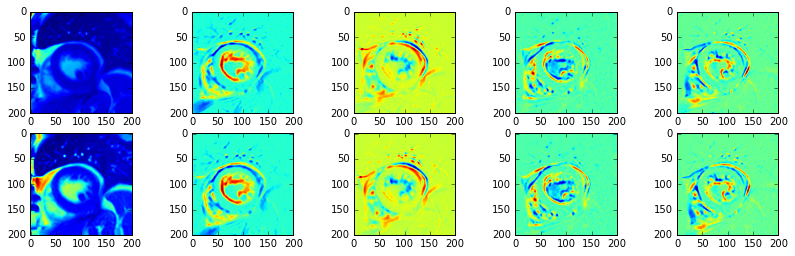

In [38]:
study=7
(X,X_2ch),y,angle = call(study,1)

from scipy import ndimage

# X,y = Xresults[414]
print y,X.shape,angle
s=len(X)//2
plt.figure(figsize=(14,4))
nw = X.shape[1]
for inw in range(nw):
    x = X[s,inw]
    plt.subplot(2,nw,inw+1)
    plt.imshow(x+128)
for inw in range(nw):
    x = X[s,inw]
    x = ndimage.interpolation.rotate(x, angle,
                                 axes=(0, 1),
                                 reshape=False,
                                 mode="nearest",
                                 cval=0.)
    plt.subplot(2,nw,nw+inw+1)
    plt.imshow(x+128)
#     print x.max(),x.min()

In [39]:
if ch2:
    print X_2ch.shape
    s=len(X_2ch)//2
    plt.figure(figsize=(14,4))
    nw = X_2ch.shape[1]
    for inw in range(nw):
        x = X_2ch[s,inw]
        plt.subplot(2,nw,inw+1)
        plt.imshow(x+128)

In [40]:
from joblib import Parallel, delayed
Xresults = Parallel(n_jobs=-1, verbose=0)(delayed(call)(i) for i in range(Na))

fn = '%s.xresults.pkl'%FN
with open(os.path.join(temp_dir,fn),'wb') as fp:
    pickle.dump(Xresults, fp, -1)

awscp(fn, upload=True)

In [41]:
# awscp(fn)
# with open(os.path.join(temp_dir,fn),'rb') as fp:
#     Xresults = pickle.load(fp)

In [42]:
def color_show(x):
    x = x.astype(float)
    intensity = x[0,:,:]
    intensity = (intensity - intensity.min())/(intensity.max() - intensity.min())
    saturation = 0.1
    colors = np.array([[1,0.,0.],[0.,0.5,0.5]])
    xx = saturation*np.ones((x.shape[1],x.shape[2],3))
    for w in range(1,min(W,4)):
        hue = np.sqrt(x[2*w-1,:,:]**2 + x[2*w,:,:]**2)
        hue = (hue - hue.min())/(hue.max()-hue.min())
        for c in range(3):
            xx[:,:,c] += (1-saturation)*colors[w-1][c]*hue
    xx *= intensity[:,:,None]
    xx = np.log(xx+1/1000.)
    xx = (xx - xx.min())/(xx.max() - xx.min())
    plt.imshow(xx)
    return xx

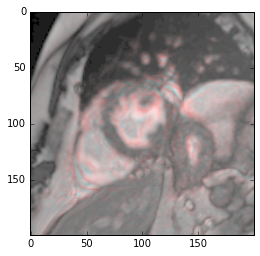

In [43]:
plt.figure(figsize=(14,4))
(img,img_2ch), _,angle = Xresults[1]
plt.subplot(121)
xx = color_show(img[4])
if ch2:
    plt.subplot(122)
    xx = color_show(img_2ch[0])

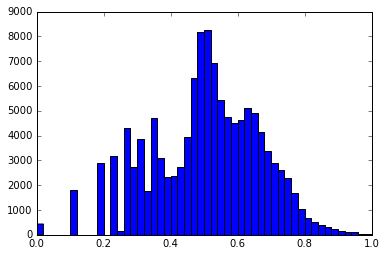

In [44]:
plt.hist(xx.ravel(),bins=50);

check all images by adding multiples of 120 to `study = s + ...` below

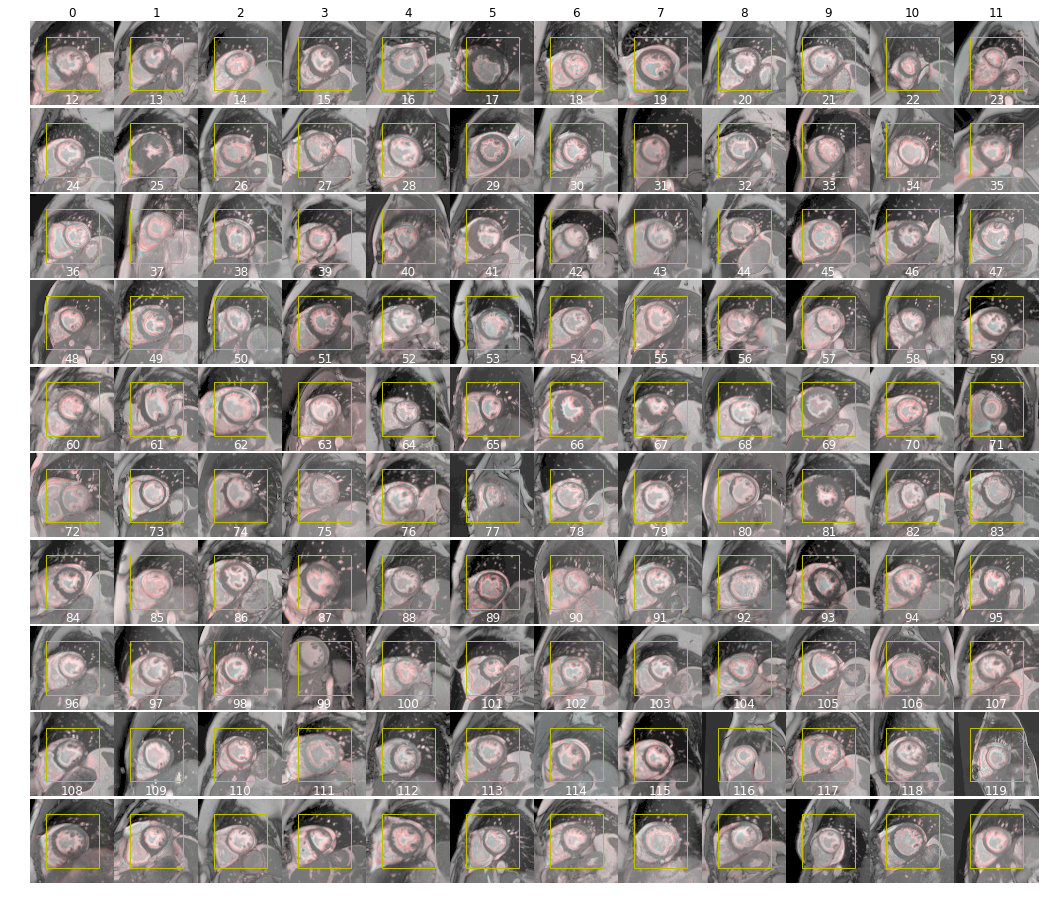

In [59]:
plt.figure(figsize=(14,12))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for s in range(4*30):
    study = s+0
    if study >= len(Xresults):
        break
        # closest_slice = res['fcn_center_slice']
    (img,_),_,angle = Xresults[study]
    closest_slice=len(img)//2
    ax = plt.subplot(2*5,2*6,s+1)
    img = img[closest_slice,:]
    img = ndimage.interpolation.rotate(img, angle,
                                 axes=(1, 2),
                                 reshape=False,
                                 mode="nearest",
                                 cval=0.)
    color_show(img)
    square = plt.Rectangle(((S-S0)/2.,(S-S0)/2.),S0,S0,color='y',fill=False,lw=1)
    ax.add_artist(square)
    plt.title(str(study))
    title_obj = plt.title('%d'%(study,))
    plt.setp(title_obj, color='k' if s < 2*6 else 'w')#,size=20)
    plt.axis('off')

In [46]:
if ch2:
    plt.figure(figsize=(14,12))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    for s in range(4*30):
        study = s+0
        if study >= Nt:
            break
            # closest_slice = res['fcn_center_slice']
        (_,img),_,angle = Xresults[study]
        closest_slice=len(img)//2
        ax = plt.subplot(2*5,2*6,s+1)
        img = img[closest_slice,:]
        color_show(img)
        plt.title(str(study))
        title_obj = plt.title('%d'%(study,))
        plt.setp(title_obj, color='k' if s < 2*6 else 'w')#,size=20)
        plt.axis('off')

In [47]:
Xresults[0][0][0].shape, Xresults[0][0][0].dtype

((11, 5, 200, 200), dtype('int8'))

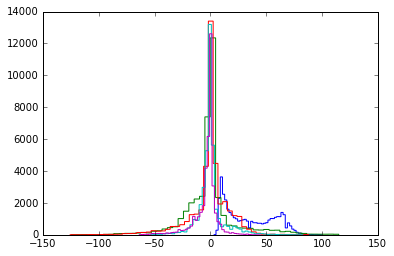

In [48]:
s=0
for inw in range(nw):
    plt.hist(X[s,inw].ravel(),bins=50,histtype='step');